<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/ROI_masked_betas(old).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Disclaimer:** the initial idea was to take the MNI coordinates by Zheng et al. (2024) as visualised in the .ipynb notebook ROIs_4HCgradient_MNI.ipynb - however, unfortunately **I could not compute the neural DSM this way as Zheng et al. (2024) used 9 single-voxel ROIs.** When there is only a single voxel, the DSM cannot be computed (see below). The reason for this is because we are doing multivariate pattern analysis (MVPA) and therefore we need to have multiple voxels. Valerio explained to me that, if we only have one voxel in an ROI, we only have one beta estimate in the ROI and therefore, we also only have one beta estimate in our vector from which we then compute the neural DSM.

Therefore, I will "archive" this notebook and take it as a template for the new **ROI_masked_betas.ipynb** which will take **atlas-based masks from ROIs_(atlas).ipynb** for the hippocampus ROIs.

In [1]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path = '/content/drive/MyDrive/Mona_Garvert_2017_fMRI_Data'

In [3]:
import zipfile
import os

Step 1: Get betas from .zip files and define paths for later application of ROI masks

In [4]:
zip_filenames = [
    "sub-04_run1_betas.zip",
    "sub-04_run2_betas.zip",
    "sub-04_run3_betas.zip",
    "sub-04_concat_betas.zip"
]

for zip_file in zip_filenames:
    zip_path = os.path.join(base_path, zip_file)
    extract_path = os.path.join(base_path, zip_file.replace(".zip", ""))
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted {zip_file} to {extract_path}")

Extracted sub-04_run1_betas.zip to /content/drive/MyDrive/Mona_Garvert_2017_fMRI_Data/sub-04_run1_betas
Extracted sub-04_run2_betas.zip to /content/drive/MyDrive/Mona_Garvert_2017_fMRI_Data/sub-04_run2_betas
Extracted sub-04_run3_betas.zip to /content/drive/MyDrive/Mona_Garvert_2017_fMRI_Data/sub-04_run3_betas
Extracted sub-04_concat_betas.zip to /content/drive/MyDrive/Mona_Garvert_2017_fMRI_Data/sub-04_concat_betas


In [5]:
# Define paths to beta estimates .zip: sub-04_run1_betas, sub-04_run2_betas, sub-04_run3_betas, sub-04_concat_betas
# List what's inside each .zip file

run1_betas_path = os.path.join(base_path, "sub-04_run1_betas")
print(os.listdir(run1_betas_path))

run2_betas_path = os.path.join(base_path, "sub-04_run2_betas")
print(os.listdir(run2_betas_path))

run3_betas_path = os.path.join(base_path, "sub-04_run3_betas")
print(os.listdir(run3_betas_path))

concat_betas_path = os.path.join(base_path, "sub-04_concat_betas")
print(os.listdir(concat_betas_path))

['sub-04_run1_object_2_beta.nii.gz', 'sub-04_run1_object_4_beta.nii.gz', 'sub-04_run1_object_6_beta.nii.gz', 'sub-04_run1_object_7_beta.nii.gz', 'sub-04_run1_object_8_beta.nii.gz', 'sub-04_run1_object_9_beta.nii.gz', 'sub-04_run1_object_10_beta.nii.gz', 'sub-04_run1_button_press_beta.nii.gz']
['sub-04_run2_object_2_beta.nii.gz', 'sub-04_run2_object_4_beta.nii.gz', 'sub-04_run2_object_6_beta.nii.gz', 'sub-04_run2_object_7_beta.nii.gz', 'sub-04_run2_object_8_beta.nii.gz', 'sub-04_run2_object_9_beta.nii.gz', 'sub-04_run2_object_10_beta.nii.gz', 'sub-04_run2_button_press_beta.nii.gz']
['sub-04_run3_object_2_beta.nii.gz', 'sub-04_run3_object_4_beta.nii.gz', 'sub-04_run3_object_6_beta.nii.gz', 'sub-04_run3_object_7_beta.nii.gz', 'sub-04_run3_object_8_beta.nii.gz', 'sub-04_run3_object_9_beta.nii.gz', 'sub-04_run3_object_10_beta.nii.gz', 'sub-04_run3_button_press_beta.nii.gz']
['sub-04_concat_object_2_beta.nii.gz', 'sub-04_concat_object_4_beta.nii.gz', 'sub-04_concat_object_6_beta.nii.gz', 'su

## ROI masks

In [6]:
base_path = '/content/drive/MyDrive/Mona_Garvert_2017_fMRI_Data/ROIs_4HCgradient/ROIs_4HCgradient'

In [7]:
# Indices for LH ROIs (see roi_filenames above)

lh_filenames = [
    "roi_1_x35_y34_z15.nii.gz",  # LH ROIs based on plotting
    "roi_2_x35_y33_z16.nii.gz",
    "roi_3_x35_y32_z17.nii.gz",
    "roi_4_x35_y31_z18.nii.gz",
    "roi_5_x35_y29_z19.nii.gz",
    "roi_6_x35_y28_z20.nii.gz",
    "roi_7_x35_y27_z21.nii.gz",
    "roi_8_x35_y26_z22.nii.gz",
    "roi_9_x35_y25_z23.nii.gz",
]

In [8]:
# Create full paths
lh_roi_paths = [os.path.join(base_path, fname) for fname in lh_filenames]

# Optionally confirm they exist
for path in lh_roi_paths:
    assert os.path.exists(path), f"Missing: {path}"

# Step 1: Apply ROI masks to Betas

Here, I take the 9 LH ROIs (based on MNI coordinates) for the hippocampus long axis (see ROIs_4HCgradient_MNI.ipynb) and I apply them as binary masks to the betas estimates (for all 3 runs concatenated) that I previously got from the GLM_FirstLevelModel.ipynb.

In [9]:
import os

In [13]:
# Paths to the 7 object beta maps (concatenated runs)

beta_filenames = [
    'sub-04_concat_object_2_beta.nii.gz',
    'sub-04_concat_object_4_beta.nii.gz',
    'sub-04_concat_object_6_beta.nii.gz',
    'sub-04_concat_object_7_beta.nii.gz',
    'sub-04_concat_object_8_beta.nii.gz',
    'sub-04_concat_object_9_beta.nii.gz',
    'sub-04_concat_object_10_beta.nii.gz',    # Excluding button_press or motion regressors
]

beta_paths = [os.path.join(concat_betas_path, f) for f in beta_filenames]

In [16]:
#! pip install nilearn

In [17]:
from nilearn.masking import apply_mask
import nibabel as nib
import numpy as np

In [18]:
# Load all ROIs

roi_masks = [nib.load(path) for path in lh_roi_paths]

In [19]:
# Dictionary: {roi_index: [voxel patterns per object]}

roi_to_patterns = {}

for i, roi in enumerate(roi_masks):
    patterns = []
    for beta_path in beta_paths:
        beta_img = nib.load(beta_path)
        voxel_values = apply_mask(beta_img, roi)
        patterns.append(voxel_values)
    roi_to_patterns[i] = np.vstack(patterns)  # shape: (n_objects, n_voxels)

# Step 2: Neural Dissimilarity Matrices (DSMs)

The neural DSMs are computed as 1 - r, where r is the Pearson correlation coefficient.

In [20]:
from scipy.spatial.distance import pdist, squareform # Valerio told me to use pdist

In [21]:
roi_to_dsms = {}

for i, patterns in roi_to_patterns.items():
    dsm = squareform(pdist(patterns, metric='correlation'))
    roi_to_dsms[i] = dsm

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

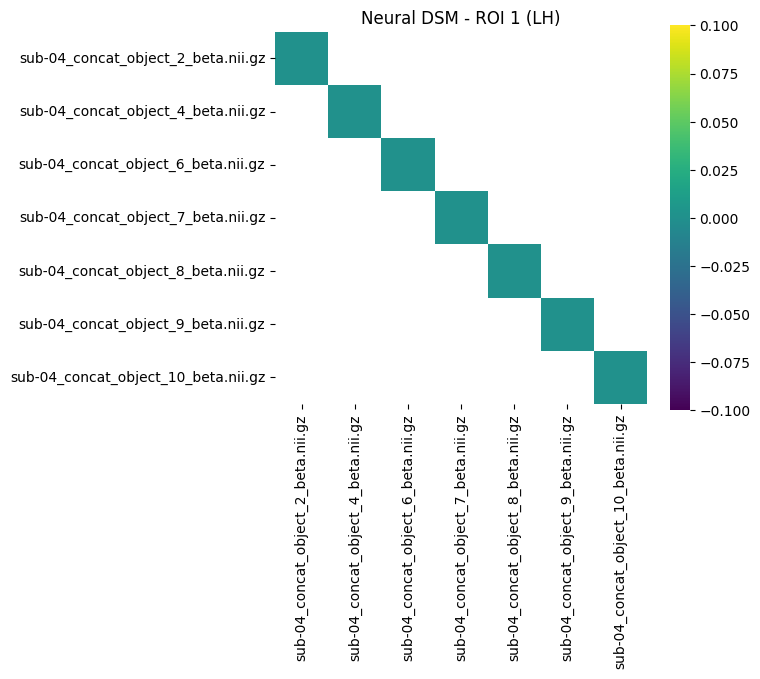

In [25]:
# Show DSM for first ROI

plt.figure(figsize=(6, 5))
sns.heatmap(roi_to_dsms[8], square=True, cmap='viridis', xticklabels=beta_filenames, yticklabels=beta_filenames)
plt.title("Neural DSM - ROI 1 (LH)")
plt.show()

In [26]:
for i, roi in enumerate(roi_masks):
    patterns = []
    for beta_path in beta_paths:
        beta_img = nib.load(beta_path)
        voxel_values = apply_mask(beta_img, roi)
        print(f"{os.path.basename(beta_path)} | mean: {voxel_values.mean():.4f} | std: {voxel_values.std():.4f}")
        patterns.append(voxel_values)
    patterns = np.vstack(patterns)
    print(f"ROI {i+1} pattern shape: {patterns.shape}")

sub-04_concat_object_2_beta.nii.gz | mean: -0.5701 | std: 0.0000
sub-04_concat_object_4_beta.nii.gz | mean: 4.2257 | std: 0.0000
sub-04_concat_object_6_beta.nii.gz | mean: -6.6963 | std: 0.0000
sub-04_concat_object_7_beta.nii.gz | mean: 7.9143 | std: 0.0000
sub-04_concat_object_8_beta.nii.gz | mean: 3.0129 | std: 0.0000
sub-04_concat_object_9_beta.nii.gz | mean: -1.9533 | std: 0.0000
sub-04_concat_object_10_beta.nii.gz | mean: -4.0681 | std: 0.0000
ROI 1 pattern shape: (7, 1)
sub-04_concat_object_2_beta.nii.gz | mean: 3.2954 | std: 0.0000
sub-04_concat_object_4_beta.nii.gz | mean: 7.2748 | std: 0.0000
sub-04_concat_object_6_beta.nii.gz | mean: -7.4492 | std: 0.0000
sub-04_concat_object_7_beta.nii.gz | mean: 12.5488 | std: 0.0000
sub-04_concat_object_8_beta.nii.gz | mean: 1.8207 | std: 0.0000
sub-04_concat_object_9_beta.nii.gz | mean: -3.4478 | std: 0.0000
sub-04_concat_object_10_beta.nii.gz | mean: -6.0870 | std: 0.0000
ROI 2 pattern shape: (7, 1)
sub-04_concat_object_2_beta.nii.gz | m